# Imports

In [1]:
import datetime
import json
import random
import IPython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import pytorch_lightning as pl

from pathlib import Path
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from ray import tune
from pytorch_lightning.loggers import TensorBoardLogger
from Models import FaceDataset, create_datasets, SingleModel, EyesModel, FullModel
from utils import get_config, train_single, train_eyes, train_full, tune_asha, get_best_results, get_tune_results, save_model, predict_screen_errors

SETTINGS, COLOURS, EYETRACKER, TF = get_config("config.ini")

%load_ext autoreload

# Dataset statistics

In [2]:
df = pd.read_csv('data/positions.csv')
region_map = np.load("data/region_map.npy").T

print("# of images: {}".format(len(df)))
print("Coverage: {}%".format(round(np.count_nonzero(region_map > 0) / region_map.size * 100, 2)))
print("Image dimensions: {}x{}px".format(SETTINGS["image_size"], SETTINGS["image_size"]))

# of images: 90020
Coverage: 99.8%
Image dimensions: 64x64px


# Data visualization

The most basic thing we can check is how well our collected training data is distributed over the screen.

Although we prioritize target locations that are near the edge of the screen during data collection, we would expect these target distributions to be somewhat normal as the pathing of the target will most likely move through the center of the screen.

The reduced sampling at the screen edges may pose some problems for accuracy at those regions, and can only really be fixed by using static edge sampling during data collection. Regardless, we can start by determining the best model architecture first, and the dealing with undersampled regions later.

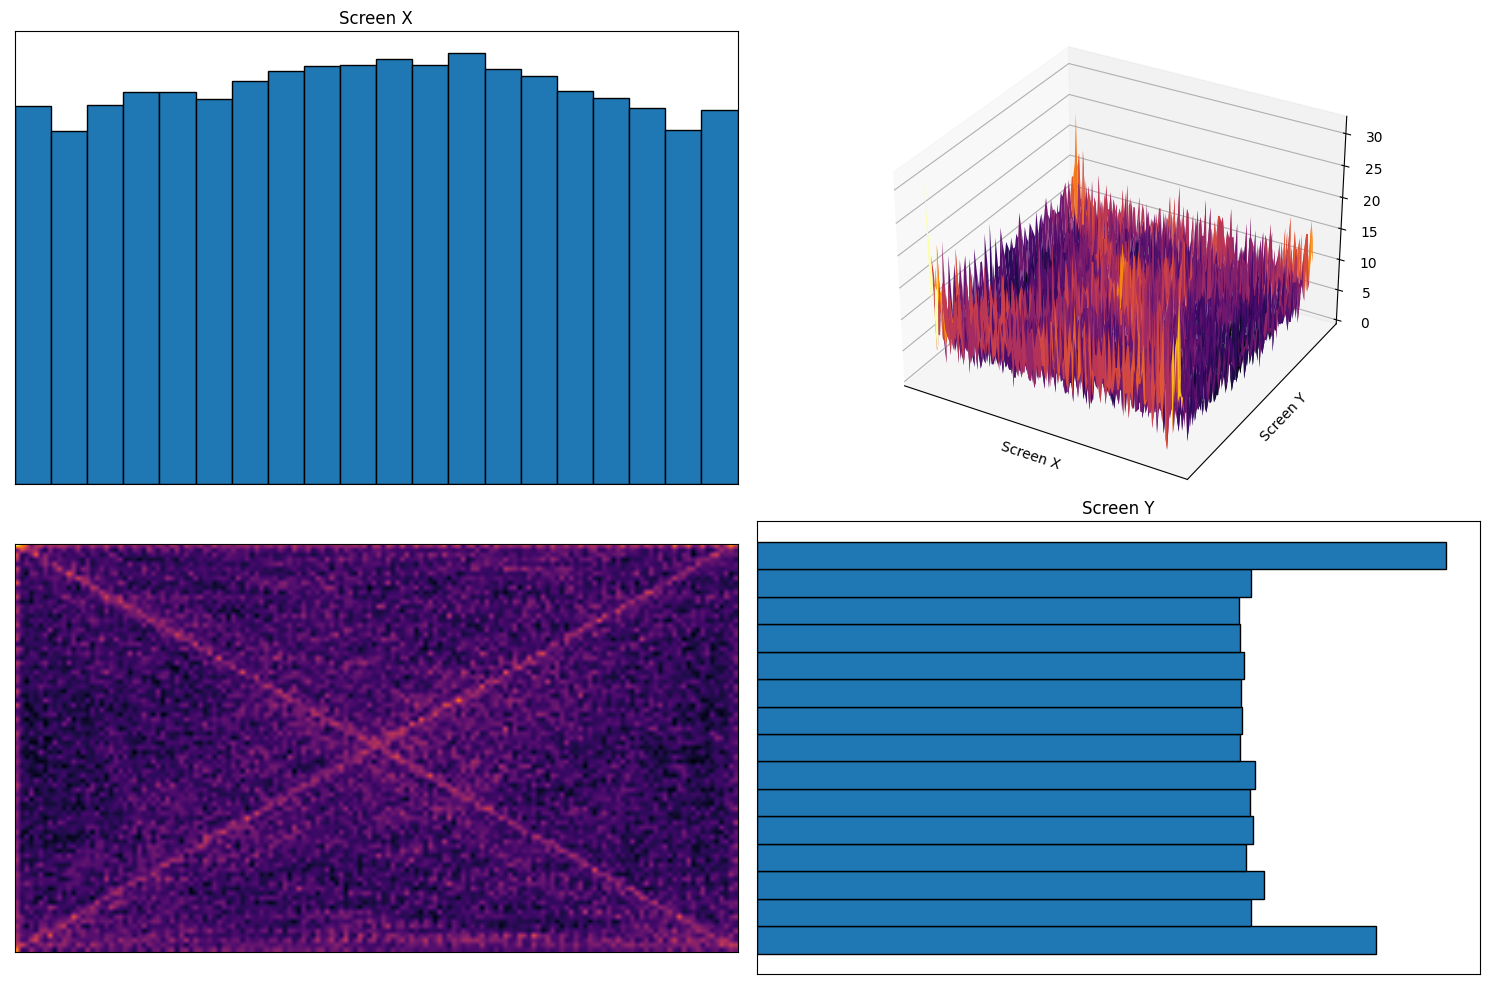

In [3]:
x = np.arange(region_map.shape[1])
y = np.arange(region_map.shape[0])
X, Y = np.meshgrid(x,y)

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(221)
ax.hist(df['x'], bins=20, edgecolor='k')
ax.set_title('Screen X')
ax.margins(x=0)

ax = fig.add_subplot(222, projection='3d')
ax.dist = 9
ax.plot_surface(X, Y, region_map, cmap="inferno")
ax.set_xlabel('Screen X', labelpad=-10)
ax.set_ylabel('Screen Y', labelpad=-10)

ax = fig.add_subplot(223)
ax.imshow(region_map, interpolation='bilinear', cmap="inferno")

ax = fig.add_subplot(224)
ax.hist(df['y'], bins=15, edgecolor='k', orientation='horizontal')
ax.set_title('Screen Y')

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()
plt.savefig('media/images/0_data_distribution.png')
plt.show()

Because we used fairly small webcam images, we had a few concerns during the data collection stage that we want to take a look at:

1. Does brightness of the screen change the colour/intensity of the screen reflection on 
the cornea?

From a couple of sample images, we can see that low screen brightness of the central monitor can split the corneal reflection into two (left), while increased screen brightness results in a bar-like reflection (right). This is a very clear artifact, even in low resolution webcam captures, and would likely affect model performance. Thankfully, we varied the screen brightness during data collection to wash away this variation across our entire dataset, as this is a "feature" that is independent of eye gaze location

In [4]:
low_bright = mpimg.imread('datar_eye/16060.jpg')
high_bright = mpimg.imread('data/r_eye/16091.jpg')
fig, axs = plt.subplots(1, 2)
axs[0].imshow(low_bright)
axs[1].imshow(high_bright)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'datar_eye/16060.jpg'

2. Is there a clear difference in eye shape and iris location at the extreme edges of the screen?

The calibration tool allowed us to record data at 9 key locations of the screen (edges and centers), and we can confirm that these locations are clearly distinguishable in low resolution images. The eye images alone might provide sufficient information for accurate eye tracking

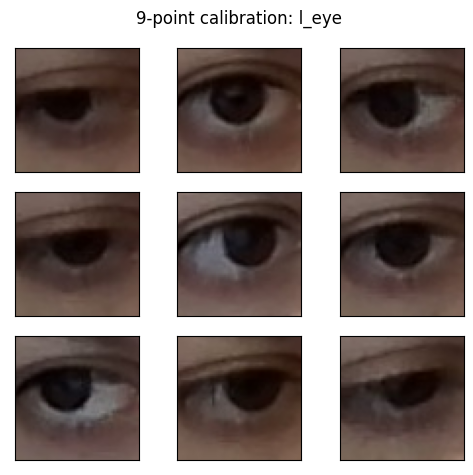

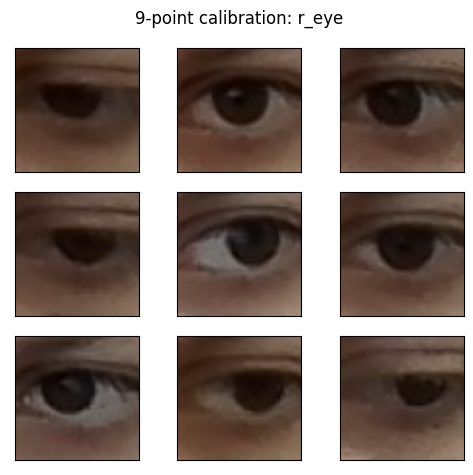

In [5]:
def plot_calibration(eye):
    calibration = [mpimg.imread('data/{}/{}.jpg'.format(eye, i)) for i in range(1,10)]
    fig, axs = plt.subplots(3, 3)
    axs[0,0].imshow(calibration[3])
    axs[0,1].imshow(calibration[6])
    axs[0,2].imshow(calibration[8])

    axs[1,0].imshow(calibration[2])
    axs[1,1].imshow(calibration[4])
    axs[1,2].imshow(calibration[7])

    axs[2,0].imshow(calibration[1])
    axs[2,1].imshow(calibration[0])
    axs[2,2].imshow(calibration[5])

    plt.suptitle("9-point calibration: {}".format(eye))
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.subplots_adjust(hspace=50)
    plt.tight_layout()
    plt.savefig('media/images/0_calibration_{}.png'.format(eye))
    plt.show()

plot_calibration('l_eye')
plot_calibration('r_eye')

# Face-only model

Although we collected a variety of image types (due to not knowing exactly what information would be sufficient for this problem), we first want to check how well a face-only model will work. Can a CNN predict accurate screen locations with only a face image, and without explicitly directing the network to focus on the eyes/head angle etc?

A face-only model would be ideal as inference would be faster, which is important when eye tracking from a live webcam feed

## Face

Start with a shallow search over many models, but few epochs, to get an idea of which hyperparameters should be fine tuned

### Explore

In [ ]:
config = {
        "seed": tune.randint(0, 10000),  # reproducible random seed for each experiment
        "bs": tune.choice([1 << i for i in range(2, 9)]),  # batch size
        "lr": tune.loguniform(1e-7, 1e-3),  # learning rate
        "filter_size": tune.choice([3, 5, 7, 9]),  # filter size (square)
        "filter_growth": tune.choice([1, 2]),  # increase filter count by a factor
        "n_filters": tune.choice([8, 16, 32, 64]),  # number of starting filters
        "n_convs": tune.choice([0, 1, 2]),  # number of conv layers
        "dense_nodes": tune.choice([16, 32, 64, 128]),  # number of nodes in fc layer
    }

analysis = tune_asha(config, data_partial=False, train_func=train_single, name="face/explore", img_types=["face"], num_samples=100, num_epochs=10, seed=87)

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"1_face_explore_training.png")

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"1_face_explore_scatter.png")

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"1_face_explore_parallel.png")

### Fine tune

In [ ]:
config = {
        "seed": tune.randint(0, 10000),  # reproducible random seed for each experiment
        "bs": tune.choice([1 << i for i in range(2, 7)]),  # batch size
        "lr": tune.loguniform(1e-4, 1e-3),  # learning rate
        "filter_size": tune.choice([3, 5, 7, 9]),  # filter size (square)
        "filter_growth": tune.choice([1, 2]),  # increase filter count by a factor
        "n_filters": tune.choice([8, 16, 32]),  # number of starting filters
        "n_convs": tune.choice([1, 2]),  # number of conv layers
        "dense_nodes": tune.choice([32, 64, 128]),  # number of nodes in fc layer
    }

analysis = tune_asha(config, data_partial=True, train_func=train_single, name="face/tune", img_types=["face"], num_samples=50, num_epochs=20, seed=87)

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"2_face_tune_scatter.png")

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"2_face_tune_parallel.png")

### Final

Get the hyperparameters from the best tuning experiments for extended training

In [ ]:
start_time = datetime.datetime.now().strftime("%Y-%b-%d %H-%M-%S")

config = get_best_results(Path.cwd()/"logs"/"face"/"tune")

pl.seed_everything(config["seed"])

d_train, d_val, d_test = create_datasets(Path.cwd(), data_partial=True, img_types=["face"], seed=config["seed"], batch_size=config["bs"])

model = SingleModel(config, "face")
trainer = pl.Trainer(
    max_epochs=50,
    gpus=[0, 1],
    accelerator="dp",
    checkpoint_callback=True,
    logger=TensorBoardLogger(save_dir=Path.cwd()/"logs", name="face/final/{}".format(start_time), log_graph=True))

trainer.fit(model, train_dataloader=d_train, val_dataloaders=d_val)

save_model(model, config, 
           Path.cwd()/"logs"/"face"/"final"/"{}".format(start_time)/"eyetracking_model.pt", 
           Path.cwd()/"logs"/"face"/"final"/"{}".format(start_time)/"eyetracking_config.json")

In [ ]:
test_results = trainer.test(test_dataloaders=d_test)
print(f"Pixel error: {np.sqrt(test_results[0]['test_loss'])}")

## Face aligned

In many face detection/classification problems it is typical to perform face alignment prior to training/inference as it eliminates the need to account to head angle. For eyetracking, my guess is that the angle of the head (from an unaligned image) is actually useful for determining gaze position, but on the other hand, it might make eye features more difficult to recognize. 

We should check whether an aligned face will actually perform worse. If aligned faces perform poorly then we can also remove the calculation from the detector, saving some computation

### Explore

A few of the 256 batch size models failed due to running out of CUDA memory, so those sizes should be pruned as they are getting too large

In [ ]:
config = {
        "seed": tune.randint(0, 10000),  # reproducible random seed for each experiment
        "bs": tune.choice([1 << i for i in range(2, 9)]),  # batch size
        "lr": tune.loguniform(1e-7, 1e-3),  # learning rate
        "filter_size": tune.choice([3, 5, 7, 9]),  # filter size (square)
        "filter_growth": tune.choice([1, 2]),  # increase filter count by a factor
        "n_filters": tune.choice([8, 16, 32, 64]),  # number of starting filters
        "n_convs": tune.choice([0, 1, 2]),  # number of conv layers
        "dense_nodes": tune.choice([16, 32, 64, 128]),  # number of nodes in fc layer
    }

analysis = tune_asha(config, data_partial=True, train_func=train_single, name="face_aligned/explore", img_types=["face_aligned"], num_samples=100, num_epochs=10, seed=87)

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"3_face_align_explore_scatter.png")

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"3_face_align_explore_parallel.png")

### Fine tune

In [ ]:
config = {
        "seed": tune.randint(0, 10000),  # reproducible random seed for each experiment
        "bs": tune.choice([1 << i for i in range(2, 7)]),  # batch size
        "lr": tune.loguniform(1e-4, 1e-3),  # learning rate
        "filter_size": tune.choice([3, 5, 7, 9]),  # filter size (square)
        "filter_growth": tune.choice([1, 2]),  # increase filter count by a factor
        "n_filters": tune.choice([16, 32, 64]),  # number of starting filters
        "n_convs": tune.choice([1, 2]),  # number of conv layers
        "dense_nodes": tune.choice([32, 64, 128]),  # number of nodes in fc layer
    }

analysis = tune_asha(config, data_partial=True, train_func=train_single, name="face_aligned/tune", img_types=["face_aligned"], num_samples=50, num_epochs=20, seed=87)

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"4_face_align_tune_scatter.png")

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"4_face_align_tune_parallel.png")

### Final

The pixel error of the aligned face model is worse than the non-aligned face

In [ ]:
config = get_best_results(Path.cwd()/"logs"/"face_aligned"/"tune")

pl.seed_everything(config["seed"])

d_train, d_val, d_test = create_datasets(Path.cwd(), data_partial=True, img_types=["face_aligned"], seed=config["seed"], batch_size=config["bs"])

model = SingleModel(config, "face_aligned")
trainer = pl.Trainer(
    max_epochs=50,
    gpus=[0,1],
    accelerator="dp",
    checkpoint_callback=True,
    logger=TensorBoardLogger(save_dir=Path.cwd()/"logs", name="face_aligned/final/{}".format(datetime.datetime.now().strftime("%Y-%b-%d %H-%M-%S")), log_graph=True))

trainer.fit(model, train_dataloader=d_train, val_dataloaders=d_val)

In [ ]:
test_results = trainer.test(test_dataloaders=d_test)
print(f"Pixel error: {np.sqrt(test_results[0]['test_loss'])}")

# Eyes

Given we are creating an eyetracker, explicitly focusing on the eyes instead of the entire head might be more useful

Its not uncommon when inputting 2 eye images to use shared weights for each subnetwork, but there is probably some value in using different weights for each due to differences in eye size/shape etc.

## Explore

In [ ]:
config = {
        "seed": tune.randint(0, 10000),  # reproducible random seed for each experiment
        "bs": tune.choice([1 << i for i in range(2, 9)]),  # batch size
        "lr": tune.loguniform(1e-7, 1e-3),  # learning rate
        "filter_size": tune.choice([3, 5, 7, 9]),  # filter size (square)
        "filter_growth": tune.choice([1, 2]),  # increase filter count by a factor
        "n_filters": tune.choice([8, 16, 32, 64]),  # number of starting filters
        "n_convs": tune.choice([0, 1, 2]),  # number of conv layers
        "dense_nodes": tune.choice([16, 32, 64, 128]),  # number of nodes in fc layer
    }

analysis = tune_asha(config, data_partial=True, train_func=train_eyes, 
                     name="eyes/explore", img_types=["l_eye", "r_eye"], 
                     num_samples=100, num_epochs=10, seed=87)

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"5_eyes_explore_scatter.png")

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"5_eyes_explore_parallel.png")

## Fine tune

In [ ]:
config = {
        "seed": tune.randint(0, 10000),  # reproducible random seed for each experiment
        "bs": tune.choice([1 << i for i in range(2, 7)]),  # batch size
        "lr": tune.loguniform(1e-4, 1e-2),  # learning rate
        "filter_size": tune.choice([3, 5, 7, 9]),  # filter size (square)
        "filter_growth": tune.choice([1, 2]),  # increase filter count by a factor
        "n_filters": tune.choice([8, 16, 32, 64]),  # number of starting filters
        "n_convs": tune.choice([1, 2]),  # number of conv layers
        "dense_nodes": tune.choice([32, 128]),  # number of nodes in fc layer
    }

analysis = tune_asha(config, data_partial=True, train_func=train_eyes, 
                     name="eyes/tune", img_types=["l_eye", "r_eye"], 
                     num_samples=50, num_epochs=20, seed=87)

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"6_eyes_tune_scatter.png")

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"6_eyes_tune_parallel.png")

## Final

The eye only model seems to perform worse than the unaligned face, so the face itself is providing some information that is useful for accurate predictions. Additional training epochs doesnt seem like it would help a huge amount given the training graphs seem like they have converged to an ideal set of parameter values

In [ ]:
config = {'seed': 6169, 'bs': 64, 'lr': 0.00048780283535549947, 'filter_size': 7, 'filter_growth': 2, 'n_filters': 16, 'n_convs': 1, 'dense_nodes': 128}

pl.seed_everything(config["seed"])

d_train, d_val, d_test = create_datasets(Path.cwd(), data_partial=True, img_types=["l_eye", "r_eye"], seed=config["seed"], batch_size=config["bs"])

model = EyesModel(config)
trainer = pl.Trainer(
    max_epochs=50,
    gpus=[1],
    accelerator="dp",
    checkpoint_callback=True,
    logger=TensorBoardLogger(save_dir=Path.cwd()/"logs", name="eyes/final/{}".format(datetime.datetime.now().strftime("%Y-%b-%d %H-%M-%S")), log_graph=True))

trainer.fit(model, train_dataloader=d_train, val_dataloaders=d_val)

In [ ]:
test_results = trainer.test(test_dataloaders=d_test)
print(f"Pixel error: {np.sqrt(test_results[0]['test_loss'])}")

# Full model

We can try combining the unaligned face and eye models, as well as bring in some other data from the webcam to hopefully get more accurate predictions. At this point it becomes difficult to directly compare against previous models because the introduction of many new input images results in a drastically different architecture/hyperparameters/training times etc. We will also need to run more experiments due to the much larger search space for the hyperparameters

We'll train a full model with aligned face + eyes + head position + head angle. We can use the aligned version of the face for more reliable feature detection as the convolutions dont need to worry about rotations, and then also directly bring in the measured head angle as a scalar into the model. This way we get better face features while preserving information about head rotation. Of course, if we had more time we could try different combinations of these inputs to find the best tradeoff between loss/memory/speed

## Explore

In [ ]:
config = {"seed": tune.randint(0, 10000),  # reproducible random seed for each experiment
          "bs": tune.choice([1 << i for i in range(2, 7)]),  # batch size
          "lr": tune.loguniform(1e-4, 1e-2),  # learning rate
          'face_filt_size': tune.choice([3, 5, 7, 9]),  # filter size (square)
          'face_filt_grow': tune.choice([1, 2]),  # increase filter count by a factor
          'n_face_filt': tune.choice([8, 16, 32, 64]),  # number of starting filters
          'n_face_conv': tune.choice([1, 2]),  # number of conv layers
          'eye_filt_size': tune.choice([3, 5, 7]),  # filter size (square)
          'eye_filt_grow': tune.choice([1, 2]),  # increase filter count by a factor
          'n_eye_filt': tune.choice([8, 16, 32]),  # number of starting filters
          'n_eye_conv': tune.choice([1, 2]),  # number of conv layers
          'head_pos_filt_size': tune.choice([3, 5, 7]),  # filter size (square)
          'head_pos_filt_grow': tune.choice([1, 2]),  # increase filter count by a factor
          'n_head_pos_filt': tune.choice([8, 16]),  # number of starting filters
          'n_head_pos_conv': tune.choice([0, 1, 2]),  # number of conv layers
          'dense_nodes': tune.choice([32, 64, 128]),  # number of nodes in fc layer
         }

analysis = tune_asha(config, data_partial=False, train_func=train_full, name="full/explore", img_types=["face_aligned", "l_eye", "r_eye", "head_pos", "head_angle"], num_samples=200, num_epochs=5, seed=87)

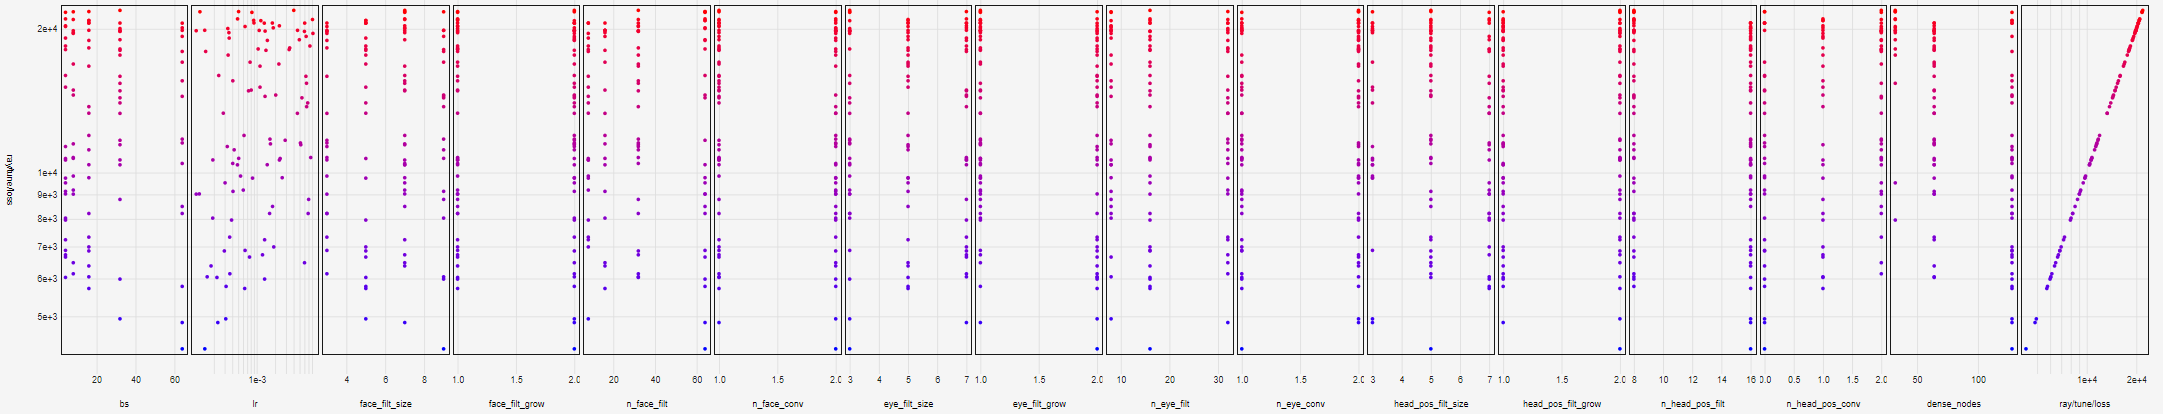

In [7]:
IPython.display.Image(Path.cwd()/"media"/"images"/"7_full_explore_scatter.png")

## Fine tune

With this number of parameter combinations, we can/should be pretty strict in pruning the ranges when fine tuning the selection process. We can see that many of the hyperparameters have a fairly clear relationship with loss, and we can use these patterns to establish more ideal ranges to reduce the search space

In [ ]:
config = {"seed": tune.randint(0, 10000),  # reproducible random seed for each experiment
          "bs": tune.choice([1 << i for i in range(4, 8)]),  # batch size
          "lr": tune.loguniform(1e-5, 1e-4),  # learning rate
          'face_filt_size': tune.choice([5, 7, 9]),  # filter size (square)
          'face_filt_grow': tune.choice([2]),  # increase filter count by a factor
          'n_face_filt': tune.choice([16, 32, 64]),  # number of starting filters
          'n_face_conv': tune.choice([2]),  # number of conv layers
          'eye_filt_size': tune.choice([3, 5]),  # filter size (square)
          'eye_filt_grow': tune.choice([2]),  # increase filter count by a factor
          'n_eye_filt': tune.choice([8, 16, 32]),  # number of starting filters
          'n_eye_conv': tune.choice([1, 2]),  # number of conv layers
          'head_pos_filt_size': tune.choice([3, 5]),  # filter size (square)
          'head_pos_filt_grow': tune.choice([2]),  # increase filter count by a factor
          'n_head_pos_filt': tune.choice([16]),  # number of starting filters
          'n_head_pos_conv': tune.choice([0]),  # number of conv layers
          'dense_nodes': tune.choice([128]),  # number of nodes in fc layer
         }

analysis = tune_asha(config, data_partial=False, train_func=train_full, name="full/tune", img_types=["face_aligned", "l_eye", "r_eye", "head_pos", "head_angle"], num_samples=50, num_epochs=10, seed=87)

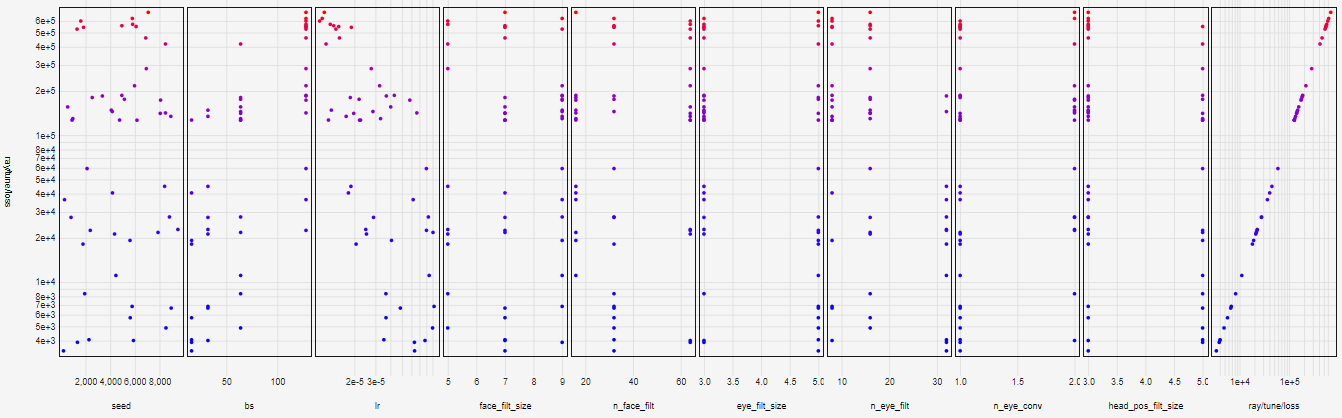

In [6]:
IPython.display.Image(Path.cwd()/"media"/"images"/"8_full_tune_scatter.png")

## Final

In [ ]:
start_time = datetime.datetime.now().strftime("%Y-%b-%d %H-%M-%S")

config = get_best_results(Path.cwd()/"logs"/"full"/"tune")

pl.seed_everything(config["seed"])

d_train, d_val, d_test = create_datasets(Path.cwd(), data_partial=False, img_types=["face_aligned", "l_eye", "r_eye", "head_pos", "head_angle"], seed=config["seed"], batch_size=config["bs"])

model = FullModel(config)
trainer = pl.Trainer(
    max_epochs=50,
    gpus=[0,1],
    accelerator="dp",
    checkpoint_callback=True,
    logger=TensorBoardLogger(save_dir=Path.cwd()/"logs", name="full/final/{}".format(start_time), log_graph=True))

trainer.fit(model, train_dataloader=d_train, val_dataloaders=d_val)

save_model(model, config, 
           Path.cwd()/"logs"/"full"/"final"/"{}".format(start_time)/"eyetracking_model.pt", 
           Path.cwd()/"logs"/"full"/"final"/"{}".format(start_time)/"eyetracking_config.json")

In [ ]:
test_results = trainer.test(test_dataloaders=d_test)
print(f"Pixel error: {np.sqrt(test_results[0]['test_loss'])}")

# Selected model

The full model performs slightly better than the face-only model in terms of error.

In terms of the structure of the network, we have a few subnetworks. A convolution block consists of `conv -> relu -> batch norm -> maxpool`:
1. Face -> convolution block -> convolution block
2. Left eye -> convolution block
3. Right eye -> convolution block
4. Head position (goes through only a single convolution layer)

The output of each of these networks is then merged with head angle information before being passed through the fully connected layers

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"9_network.png")

In [ ]:
model.summarize(mode='full')
print(model)
print(model.hparams)

## Feature maps

We can use hooks to detach specific layers of the network and plot the feature maps post-convolution.

### Face

Its difficult to determine what the kernels are learning to produce such feature maps, but you can see, for example that some have learned to separate the face from the background, and quite a few have learned the boundary of where the face is vs. my headrest and background

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Load model
config = get_best_results(Path.cwd()/"logs"/"full"/"tune")
model = FullModel(config)
model.load_state_dict(torch.load('trained_models/eyetracking_model.pt'))

# Select layer to visualize
target_layer = 'face_conv'
model.face_convs[0].face_conv.register_forward_hook(get_activation(target_layer))

# Get an input image
img_types = ["face_aligned", "l_eye", "r_eye", "head_pos", "head_angle"]
dataset = FaceDataset(Path.cwd(), False, *img_types)
ds = dataset[1]
img_list = [ds[img].unsqueeze(0) for img in img_types]
_ = model(*img_list)

# Plot grid of feature maps
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(8, 8),
                 axes_pad=0.1)

act = activation[target_layer].squeeze()
for ax, im in zip(grid, act):
    ax.imshow(im, cmap='bone')

plt.tight_layout()
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.savefig('media/images/9_face_feature_maps.png')
plt.show()

### Eyes

The 2 indented regions over the cornea are from the triple monitor setup I have

In [ ]:
# Select layer to visualize
target_layer = 'l_conv'
model.r_convs[0].r_conv.register_forward_hook(get_activation(target_layer))

# Get an input image
img_types = ["face_aligned", "l_eye", "r_eye", "head_pos", "head_angle"]
dataset = FaceDataset(Path.cwd(), False, *img_types)
ds = dataset[16060]
img_list = [ds[img].unsqueeze(0) for img in img_types]
_ = model(*img_list)

# Plot grid of feature maps
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(8, 8),
                 axes_pad=0.1)

act = activation[target_layer].squeeze()
for ax, im in zip(grid, act):
    ax.imshow(im, cmap='bone')

plt.tight_layout()
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.savefig('media/images/9_eye_feature_maps.png')
plt.show()

# Error over screen space

While the full model performed better than the face-only model overall (pixel error: 45 vs 49px), what really matters is error for each region of the screen. So we need to check how that error is distributed in screen space, as well as the histogram of those errors

As we can see from the plots below, the largest prediction errors are found in the lower corners, and right edge of the screen

## Face model

In [ ]:
errors = predict_screen_errors('face', data_partial=True,
                               path_model="logs/face/final/2021-Jan-04 00-35-35/eyetracking_model.pt", 
                               path_config="logs/face/final/2021-Jan-04 00-35-35/eyetracking_config.json", 
                               path_errors="logs/face/final/2021-Jan-04 00-35-35/eyetracking_errors.npy",
                               path_plot="media/images/10_errors_face.png")

## Full model


Average error: 33.96px over 9002 predictions


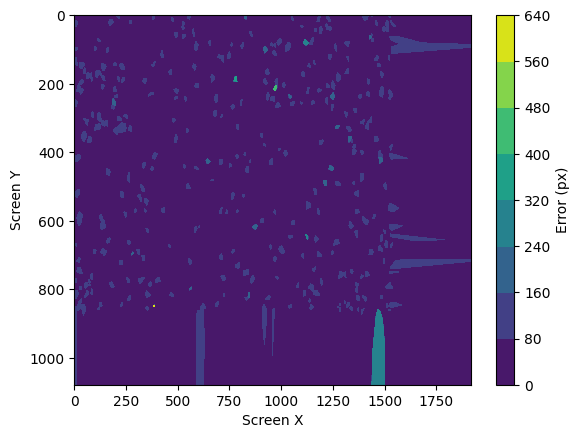

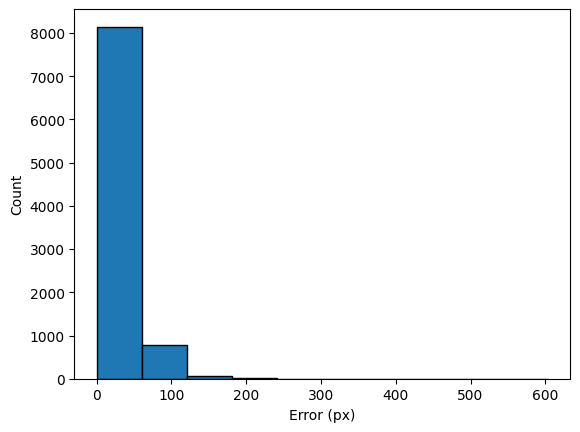

In [2]:
errors = predict_screen_errors("face_aligned", "l_eye", "r_eye", "head_pos", "head_angle", data_partial=False,
                               path_model="logs/full/final/2023-Aug-10 02-35-49/eyetracking_model.pt", 
                               path_config="logs/full/final/2023-Aug-10 02-35-49/eyetracking_config.json", 
                               path_errors="logs/full/final/2023-Aug-10 02-35-49/eyetracking_errors.npy",
                               path_plot="media/images/10_errors_full.png")

# Extended training with more data

One way to address the edge/corner problem would be collect more data, but with an increased focus on screen edges and corners to upsample those regions. This is somewhat difficult to do because as the target travels to/from the edges and corners, it will necessarily pass through the center of the screen so we end up upsampling those regions as well, but as long as we get more data from the edges our model should be more accurate

## Extended dataset statistics

In [ ]:
df = pd.read_csv('data/positions.csv')
region_map = np.load("data/region_map.npy").T

print("# of images: {}".format(len(df)))
print("Coverage: {}%".format(round(np.count_nonzero(region_map > 0) / region_map.size * 100, 2)))
print("Image dimensions: {}x{}px".format(SETTINGS["image_size"], SETTINGS["image_size"]))

x = np.arange(region_map.shape[1])
y = np.arange(region_map.shape[0])
X, Y = np.meshgrid(x,y)

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(221)
ax.hist(df['x'], bins=20, edgecolor='k')
ax.set_title('Screen X')
ax.margins(x=0)

ax = fig.add_subplot(222, projection='3d')
ax.dist = 9
ax.plot_surface(X, Y, region_map, cmap="inferno")
ax.set_xlabel('Screen X', labelpad=-10)
ax.set_ylabel('Screen Y', labelpad=-10)

ax = fig.add_subplot(223)
ax.imshow(region_map, interpolation='bilinear', cmap="inferno")

ax = fig.add_subplot(224)
ax.hist(df['y'], bins=15, edgecolor='k', orientation='horizontal')
ax.set_title('Screen Y')

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()
plt.show()

## Training

In [ ]:
start_time = datetime.datetime.now().strftime("%Y-%b-%d %H-%M-%S")

config = get_best_results(Path.cwd()/"logs"/"full"/"tune")

pl.seed_everything(config["seed"])

d_train, d_val, d_test = create_datasets(Path.cwd(), data_partial=False, img_types=["face_aligned", "l_eye", "r_eye", "head_pos", "head_angle"], seed=config["seed"], batch_size=config["bs"])

model = FullModel(config)
trainer = pl.Trainer(
    max_epochs=50,
    gpus=[0,1],
    accelerator="dp",
    checkpoint_callback=True,
    logger=TensorBoardLogger(save_dir=Path.cwd()/"logs", name="full_all/final/{}".format(start_time), log_graph=True))

trainer.fit(model, train_dataloader=d_train, val_dataloaders=d_val)

save_model(model, config, 
           Path.cwd()/"logs"/"full_all"/"final"/"{}".format(start_time)/"eyetracking_model.pt", 
           Path.cwd()/"logs"/"full_all"/"final"/"{}".format(start_time)/"eyetracking_config.json")

In [ ]:
test_results = trainer.test(test_dataloaders=d_test)
print(f"Pixel error: {np.sqrt(test_results[0]['test_loss'])}")

In [ ]:
errors = predict_screen_errors("face_aligned", "l_eye", "r_eye", "head_pos", "head_angle", data_partial=False, steps=20,
                               path_model="logs/full_all/final/2021-Jan-04 23-40-34/eyetracking_model.pt", 
                               path_config="logs/full_all/final/2021-Jan-04 23-40-34/eyetracking_config.json", 
                               path_errors="logs/full_all/final/2021-Jan-04 23-40-34/eyetracking_errors.npy",
                               path_plot="media/images/11_errors_full_all.png")